<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Fast Food Chains and Price Discrimination

_Authors: Kiefer Katovich (SF), Mario Carrillo (SF)_

---

This group lab uses a 1994 data set of detailed prices on items sold at more than 400 Burger King, Wendy's, KFC, and [Roy Rogers](https://en.wikipedia.org/wiki/Roy_Rogers_Restaurants) restaurants in New Jersey and Pennsylvania.

The data set is a restricted version of the data set used in this publication:

> [K. Graddy (1997), "Do Fast-Food Chains Price Discriminate on the Race and Income Characteristics of an Area?" Journal of Business and Economic Statistics 15, 391-401](http://people.brandeis.edu/~kgraddy/published%20papers/GraddyK_jbes1997.pdf).

**The goal of this exercise is to evaluate whether or not fast food restaurants are using discriminatory pricing.** This is a fairly open-ended prompt. It's up to you to determine how to quantify pricing discrimination using the following groups of variables:
- The price of fast food items, which can be a metric of discriminatory practices.
- The proportion of African Americans residents, low-income residents, and residents without a car.

---

### In Groups, You Should:

1) **Load and examine the data.**

2) **Perform any necessary data cleaning.**

3) **Conduct an exploratory data analysis relevant to the goals of the project.** What variables are you interested in for your target(s) and predictors? What types of relationships do you see in the data that will inform your analysis?

4) **Formulate and formally define your hypotheses.** Based on the prompt and your EDA, come up with a plan for testing each one.

5) **Construct regression models to test each hypothesis.** What are your findings? Do they support the hypothesis? What are the limitations and assumptions of your approach? 

6) **[Bonus] Cross-validate the results of your regression.** If the results support your hypotheses, do they hold up during cross-validation or a train/test split?

7) **Prepare a brief (10-minute) presentation on the findings.** Each group's presentation should include your questions, models, and findings.
    - Be concise! Only include relevant information in your presentation.
    - Visuals are nice, but don't overdo it.
    - Don't just talk about your model's significance or metrics. Interpret the coefficients. What are the implications?
    - What future hypotheses could you test going forward?


> *Note*: If you are interested, the full data set is also available in the "datasets" folder under the name `discrim_full.csv`.

### Data Set Characteristics

    :Number of Instances: 410
    
    :Attribute Information
    
    psoda         price of medium soda
    pfries        price of small fries
    pentree       price entree (burger or chicken)
    wagest        starting wage
    nmgrs         number of managers
    nregs         number of registers
    hrsopen       hours open
    emp           number of employees
    compown       =1 if company owned
    chain         BK = 1, KFC = 2, Roy Rogers = 3, Wendy's = 4
    density       population density, town
    crmrte        crime rate, town
    state         NJ = 1, PA = 2
    prpblck       proportion black, zipcode
    prppov        proportion in poverty, zipcode
    prpncar       proportion no car, zipcode
    hseval        median housing value, zipcode
    nstores       number of stores, zipcode
    income        median family income, zipcode
    county        county label
    NJ            =1 for New Jersey
    BK            =1 if Burger King
    KFC           =1 if Kentucky Fried Chicken
    RR            =1 if Roy Rogers

In [416]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/regressions packages
from sklearn import linear_model
from sklearn.metrics import r2_score

# Make sure your charts appear in the notebook
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [417]:
food = pd.read_csv('./datasets/discrim.csv')

In [418]:
food.head()

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,prppov,prpncar,hseval,nstores,income,county,NJ,BK,KFC,RR
0,1.12,1.06,1.02,4.25,3.0,5.0,16.0,27.5,1,3,...,0.036579,0.078843,148300.0,3,44534.0,18,1,0,0,1
1,1.06,0.91,0.95,4.75,3.0,3.0,16.5,21.5,0,1,...,0.036579,0.078843,148300.0,3,44534.0,18,1,1,0,0
2,1.06,0.91,0.98,4.25,3.0,5.0,18.0,30.0,0,1,...,0.087907,0.269430,169200.0,3,41164.0,12,1,1,0,0
3,1.12,1.02,1.06,5.00,4.0,5.0,16.0,27.5,0,3,...,0.059123,0.136690,171600.0,3,50366.0,10,1,0,0,1
4,1.12,NaN,0.49,5.00,3.0,3.0,16.0,5.0,0,1,...,0.025414,0.073802,249100.0,1,72287.0,10,1,1,0,0


In [419]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 24 columns):
psoda      402 non-null float64
pfries     393 non-null float64
pentree    398 non-null float64
wagest     390 non-null float64
nmgrs      404 non-null float64
nregs      388 non-null float64
hrsopen    410 non-null float64
emp        404 non-null float64
compown    410 non-null int64
chain      410 non-null int64
density    409 non-null float64
crmrte     409 non-null float64
state      410 non-null int64
prpblck    409 non-null float64
prppov     409 non-null float64
prpncar    409 non-null float64
hseval     409 non-null float64
nstores    410 non-null int64
income     409 non-null float64
county     410 non-null int64
NJ         410 non-null int64
BK         410 non-null int64
KFC        410 non-null int64
RR         410 non-null int64
dtypes: float64(15), int64(9)
memory usage: 77.0 KB


In [420]:
food['nstores'].value_counts()

3    103
2    103
1     73
4     52
6     25
5     24
7     19
8     11
Name: nstores, dtype: int64

In [421]:
food[(food['county'] == 18) & (food['RR'] == 1)]

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,prppov,prpncar,hseval,nstores,income,county,NJ,BK,KFC,RR
0,1.12,1.06,1.02,4.25,3.0,5.0,16.0,27.50,1,3,...,0.036579,0.078843,148300.0,3,44534.0,18,1,0,0,1
46,1.02,1.07,0.95,5.00,4.0,4.0,17.0,22.00,0,3,...,0.027804,0.026637,161300.0,3,54216.0,18,1,0,0,1
56,1.12,1.07,1.06,NaN,2.0,6.0,11.5,17.25,1,3,...,0.047436,0.085971,155300.0,4,48350.0,18,1,0,0,1
271,1.20,1.17,2.35,5.00,2.0,4.0,7.0,3.00,1,3,...,0.016036,0.012972,204000.0,1,57672.0,18,1,0,0,1
306,1.10,1.00,0.74,5.25,3.0,4.0,16.0,30.00,0,3,...,0.022561,0.038316,188400.0,8,63905.0,18,1,0,0,1
309,1.09,NaN,0.95,4.62,3.0,4.0,16.0,18.00,0,3,...,0.022561,0.038316,188400.0,8,63905.0,18,1,0,0,1
310,NaN,NaN,NaN,NaN,4.0,5.0,12.5,20.00,0,3,...,0.022561,0.038316,188400.0,8,63905.0,18,1,0,0,1
311,1.12,1.07,1.10,4.25,5.0,NaN,17.0,21.75,1,3,...,0.038116,0.033687,161200.0,4,51806.0,18,1,0,0,1
315,1.12,1.07,1.06,4.75,2.0,5.0,17.0,14.00,1,3,...,0.026324,0.051031,156200.0,1,50884.0,18,1,0,0,1
324,1.06,1.06,1.06,5.50,4.0,5.0,17.0,27.50,0,3,...,0.146482,0.252790,126100.0,3,33462.0,18,1,0,0,1


In [422]:
food['prpblck'].value_counts()

0.000000    9
0.009989    6
0.023150    6
0.921056    5
0.208941    5
0.034385    5
0.607332    5
0.159131    5
0.039983    5
0.070283    4
0.065714    4
0.249817    4
0.185530    4
0.106456    4
0.173280    4
0.019091    4
0.032352    3
0.105874    3
0.359895    3
0.058840    3
0.007601    3
0.004454    3
0.195367    3
0.009186    3
0.091129    3
0.022458    3
0.041444    3
0.006095    3
0.036297    3
0.073496    3
           ..
0.615669    1
0.022145    1
0.013911    1
0.236974    1
0.029728    1
0.056068    1
0.018677    1
0.386551    1
0.111835    1
0.013148    1
0.000892    1
0.017352    1
0.698250    1
0.001305    1
0.016090    1
0.011820    1
0.052839    1
0.014477    1
0.011885    1
0.160128    1
0.026728    1
0.014763    1
0.003633    1
0.017508    1
0.005836    1
0.012478    1
0.044304    1
0.000262    1
0.433610    1
0.057046    1
Name: prpblck, Length: 241, dtype: int64

In [424]:
food['county'].value_counts()

2     35
18    32
6     31
20    29
10    28
19    23
5     21
21    20
12    19
23    17
1     16
28    15
4     15
15    15
24    14
17    13
11    13
14     8
9      8
7      7
26     7
16     4
22     4
27     4
29     4
8      3
25     3
13     1
3      1
Name: county, dtype: int64

In [426]:
corr_dict = {}
for i in range(len(food.columns)):
    for j in range(len(food.columns)):
        if j >= i:
            cor = food.corr().values[i][j]
            if (np.abs(cor) > 0.7 and np.abs(cor) < 1):
                corr_dict[(food.columns[i], food.columns[j])] = cor

In [427]:
corr_dict

{('pentree', 'KFC'): 0.8790596699667645,
 ('chain', 'BK'): -0.8519096067586456,
 ('prppov', 'prpncar'): 0.9316695852668941,
 ('prppov', 'income'): -0.7249557247030409,
 ('hseval', 'income'): 0.8384240437631255}

**T-test for proportion of black in 2 groups**

In [430]:
food['black'] = [1 if prop > 0.1 else 0 for prop in food['prpblck']]

In [431]:
food['meal'] = food['psoda'] + food['pfries'] + food['pentree']

In [432]:
x1 = food[food['black'] == 1]['meal']
x1.dropna(inplace=True)
x2 = food[food['black'] == 0]['meal']
x2.dropna(inplace=True)
t_stat, p_value = stats.ttest_ind(x1,x2)
print('t-statistic={}, p-value={}'.format(t_stat, p_value))

t-statistic=3.398049350715034, p-value=0.0007495221603568831


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:3896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [433]:
print (x1.mean(), x2.mean())

3.45396694214876 3.216052631578947


In [434]:
food['black2'] = [1 if prop > 0.2 else 0 for prop in food['prpblck']]

In [435]:
x1 = food[food['black2'] == 1]['meal']
x1.dropna(inplace=True)
x2 = food[food['black2'] == 0]['meal']
x2.dropna(inplace=True)
t_stat, p_value = stats.ttest_ind(x1,x2)
print('t-statistic={}, p-value={}'.format(t_stat, p_value))

t-statistic=3.8758562232660685, p-value=0.000124879936630659


In [436]:
print (x1.mean(), x2.mean())

3.5666666666666673 3.233644859813082


In [437]:
kfc = food[food['KFC'] == 1].copy()
kfc_x1 = kfc[kfc['black2'] == 1]['meal']
kfc_x1.dropna(inplace=True)
kfc_x2 = kfc[kfc['black2'] == 0]['meal']
kfc_x2.dropna(inplace=True)
t_stat, p_value = stats.ttest_ind(kfc_x1,kfc_x2)
print('t-statistic={}, p-value={}'.format(t_stat, p_value))
print (kfc_x1.mean(), kfc_x2.mean())

t-statistic=0.28221602347653874, p-value=0.7785449938405856
4.361739130434782 4.333090909090909


**Linear regression on one feature**

In [443]:
food.dropna(inplace=True)
predictor = food['prpblck']
price = food['meal']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictor.to_frame(), price, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [444]:
price_test_pred = lr.predict(X_test)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


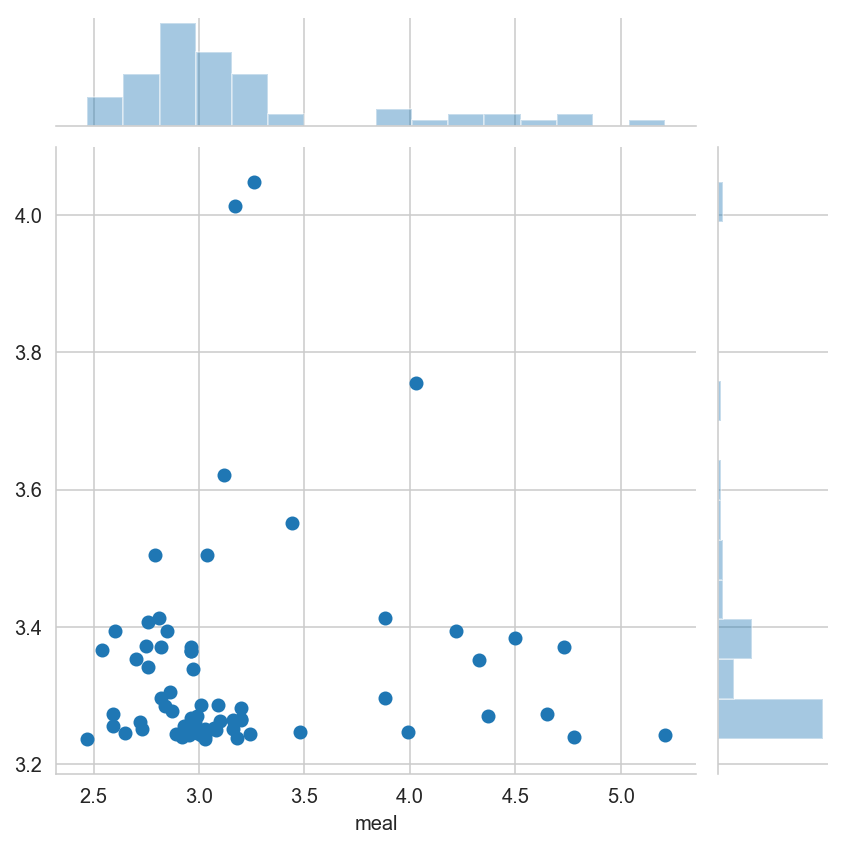

In [447]:
sns.jointplot(y_test, price_test_pred)

In [448]:
r2_score(y_test, price_test_pred)

-0.08484536655039521

In [449]:
predictor = food[['prpblck','income']]
price = food['meal']
X_train, X_test, y_train, y_test = train_test_split(predictor, price, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [450]:
price_test_pred = lr.predict(X_test)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


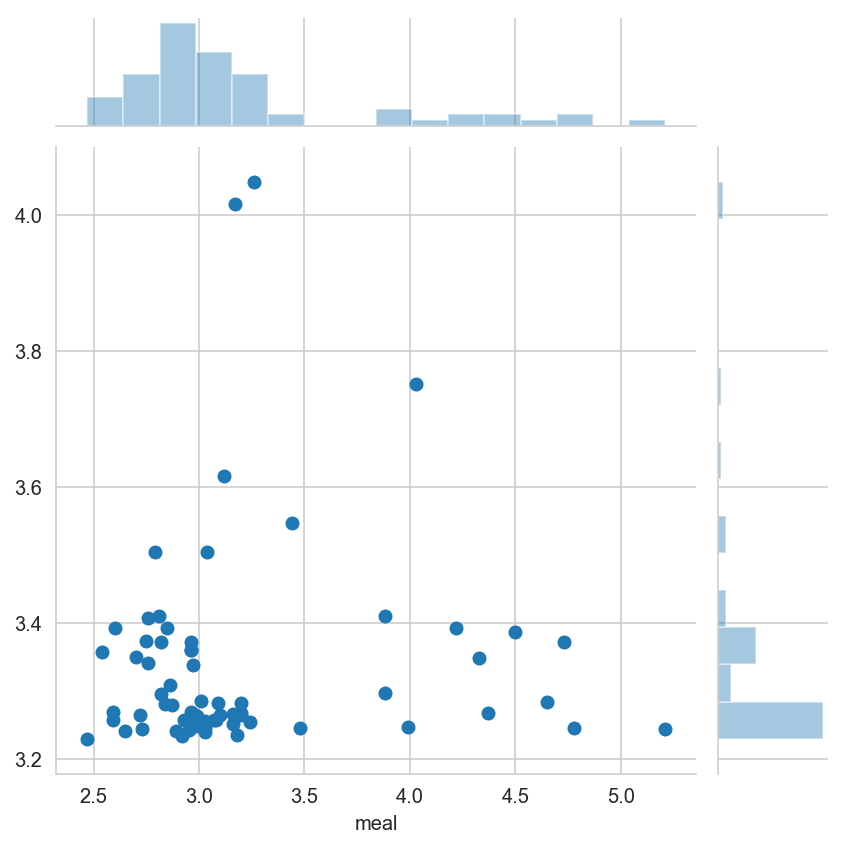

In [451]:
sns.jointplot(y_test, price_test_pred)

In [452]:
r2_score(y_test, price_test_pred)

-0.08167062903411515

**Regression with lasso regularization**

In [453]:
food_meal_nonnull = food[~food['meal'].isnull()]

In [454]:
food_nonnull = food.dropna().copy()
food_nonnull.drop(44, inplace=True)

In [455]:
X = food_nonnull.loc[:, 'wagest':'black2'].copy()
X.drop(['meal', 'chain', 'state', 'county'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337 entries, 0 to 409
Data columns (total 20 columns):
wagest     337 non-null float64
nmgrs      337 non-null float64
nregs      337 non-null float64
hrsopen    337 non-null float64
emp        337 non-null float64
compown    337 non-null int64
density    337 non-null float64
crmrte     337 non-null float64
prpblck    337 non-null float64
prppov     337 non-null float64
prpncar    337 non-null float64
hseval     337 non-null float64
nstores    337 non-null int64
income     337 non-null float64
NJ         337 non-null int64
BK         337 non-null int64
KFC        337 non-null int64
RR         337 non-null int64
black      337 non-null int64
black2     337 non-null int64
dtypes: float64(12), int64(8)
memory usage: 55.3 KB


In [458]:
y = food_nonnull['meal']
# y.info()

In [459]:
lassoregcv = LassoCV(n_alphas=500, random_state=42, max_iter=10000, normalize=True)
lassoregcv.fit(X, y)
lassoregcv.alpha_

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.00028932934095105527

In [460]:
lasso = Lasso(alpha=lassoregcv.alpha_)
scores_lasso = cross_val_score(lasso, X, y.to_frame(), cv=10)
scores_lasso

array([0.85548015, 0.64630451, 0.61366115, 0.8393865 , 0.70959318,
       0.79900344, 0.66010797, 0.55938659, 0.6540343 , 0.78505141])

In [461]:
np.mean(scores_lasso)

0.7122009213051512

In [462]:
lasso.fit(X,y)
y_pred = lasso.predict(X)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


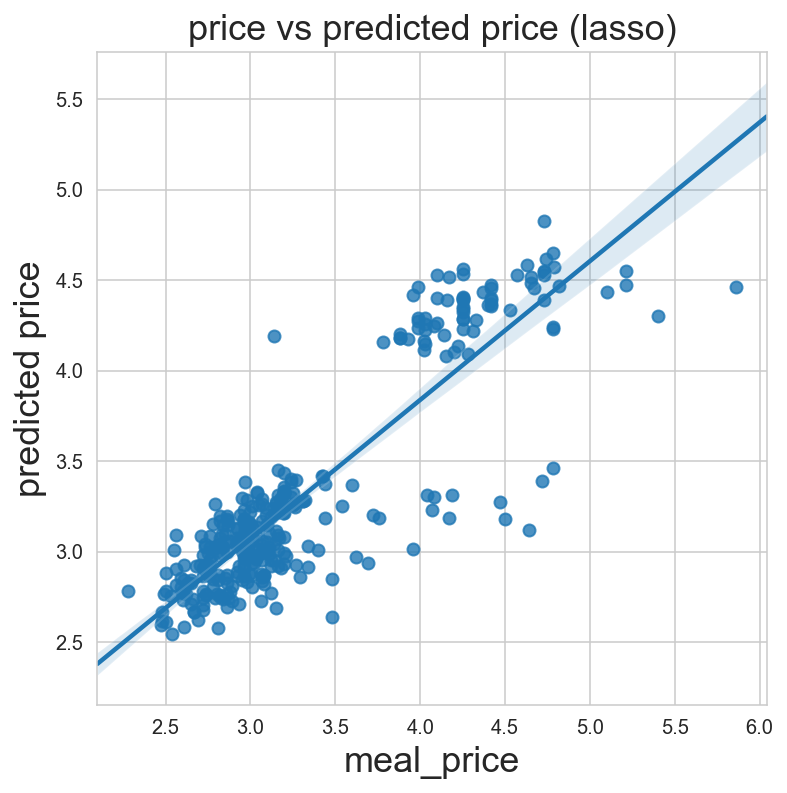

In [463]:
plt.figure(figsize=(6,6))
sns.regplot(y, y_pred)
plt.xlabel('meal_price', fontsize=18)
plt.ylabel('predicted price', fontsize=18)
plt.title('price vs predicted price (lasso)', fontsize=18)
# plt.legend()
plt.show()

In [464]:
np.abs(lassoregcv.coef_)
sorted_coeff = -np.sort(-np.abs(lassoregcv.coef_))
sorted_coeff

array([1.30714930e+00, 1.27265248e+00, 1.03619084e+00, 2.98492057e-01,
       1.76350348e-01, 1.27087250e-01, 9.92497050e-02, 9.19756974e-02,
       1.91319683e-02, 1.71862830e-02, 9.48859219e-03, 8.84545052e-03,
       1.70831309e-03, 6.37014655e-06, 2.43746620e-06, 2.28918171e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [465]:
pred_dict = dict(zip(X.columns, lassoregcv.coef_))
pred_dict

{'wagest': 0.017186282986548597,
 'nmgrs': -0.0,
 'nregs': 0.009488592192688602,
 'hrsopen': 0.0,
 'emp': -0.001708313090194412,
 'compown': -0.0992497049654714,
 'density': 2.289181710803468e-06,
 'crmrte': 1.0361908371061301,
 'prpblck': 0.29849205655949057,
 'prppov': -1.3071492958011046,
 'prpncar': -0.0,
 'hseval': 2.4374661952616792e-06,
 'nstores': -0.019131968326074292,
 'income': -6.370146554626169e-06,
 'NJ': 0.0919756974230327,
 'BK': -0.1763503476017072,
 'KFC': 1.27265248498687,
 'RR': 0.12708724993032516,
 'black': 0.0,
 'black2': 0.008845450516572385}

In [480]:
top = X.columns[np.abs(lassoregcv.coef_) >= sorted_coeff[9]]
top

Index(['wagest', 'compown', 'crmrte', 'prpblck', 'prppov', 'nstores', 'NJ',
       'BK', 'KFC', 'RR'],
      dtype='object')

In [467]:
pred_dict['crmrte']

1.0361908371061301

In [468]:
pred_dict['prpblck']

0.29849205655949057

In [469]:
pred_dict['prppov']

-1.3071492958011046

In [470]:
pred_dict['BK']

-0.1763503476017072

In [471]:
pred_dict['KFC']

1.27265248498687

In [485]:
pred_dict['NJ']

0.0919756974230327

In [486]:
pred_dict['RR']

0.12708724993032516

In [487]:
pred_dict['wagest']

0.017186282986548597

In [488]:
pred_dict['compown']

-0.0992497049654714

In [489]:
pred_dict['nstores']

-0.019131968326074292

**Linear regression using top 5 features**

In [491]:
linreg = LinearRegression()
k = 10
best_X = X[['crmrte', 'prpblck', 'prppov', 'BK', 'KFC']]
# best_X = X[['crmrte', 'hseval', 'prppov', 'BK', 'KFC']]

# best_X = (best_X - best_X.mean())/ best_X.std()
scores_lin = cross_val_score(linreg, best_X, y.to_frame(), cv=k)
scores_lin

array([0.79598469, 0.58540187, 0.52906948, 0.85863553, 0.7106869 ,
       0.75378644, 0.69480682, 0.5978722 , 0.67035866, 0.65724498])

In [492]:
np.mean(scores_lin)

0.6853847569703866